---
Helo ML Classification (CNN)
---
James Shima 
---
---
CLASSES (DATASET 1: data.json):
1.       Bench, sFoLqgI5afw6UcfrmxZX
2.       Barbell Curl, bkziJY2HV6G0NF0zUUqU
3.       Back Squat, lCcTdGNrsSUCUcWFpdHh
4.       Overhead Press, 9PJxOlCdxcbFBvZw7gk9
5.       Deadlift, fZXPgJEMjxIMjz5ZxXqZ
---
DATASET 2: TBD... April7-Collection.json

There were 20 collection events in timestamp order (oldest is #1, newest is #20):
1. Blank
2. Incline bench 135 lbs - 8 reps
3. Incline bench 185 lbs - 8 reps
4. Lat pull down 180 lbs - 8 reps
5. Y-t-w 7.5 lbs - 10 ,10 , 10 for a total of 30
6. Incline bench 195 lbs - 8 reps
7. Lat pull down 180 lbs - 8 reps
8. Y-t-w 7.5 - 10 ,10 , 10 for a total of 30
9. Incline bench 205 lbs - 7 reps
10. Lat pull down 180 lbs - 8 reps
11. Y-t-w 7.5 lbs - 10 ,10 ,10 for a total of 40
12. SA dumb bench 80 - 16 total reps (8 on R then 8 on L)
13. Db front, side raise 25 lb - 10, 10 for a total of 20 (held on right)
14. Smith BB front lift 95 lb - 10 reps
15. SA dumb bench 80 lb - 16 total reps (8 on R then 8 on L)
16. Db front, side raise 25 lb- 10, 10 for a total of 20 (held on right)
17. Smith BB front lift 95lb - 10 reps
18. 80 lb - 16 total reps (8 on R then 8 on L)
19. Db front, side raise 25 lb - 10, 10 for a total of 20 (held on right)
20. Smith BB front lift 95 lb- 10 reps
---

In [ ]:
#Libraries:
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,Dropout,InputLayer
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from tensorflow import math as tfm
from scipy.io import savemat
from mat4py import loadmat

In [2]:
class_labels = {0:"Bench", 1:"Curl", 2:"Squat", 3:"Overhead Press", 4:"Deadlift"}

# ============== Helper Functions ==================
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tfm.exp(-0.1)


def dc_block(dataset, time, init_coeff=None, fc=0.1):
    Ts = np.mean(np.diff(time))
    fs = 1/Ts
    #Ns = len(Ts)
    #time = time-time[0] #already did in main...

    x_diff = np.diff(dataset)
    y = np.zeros(len(dataset))
    wc = 2*np.pi*fc/fs
    ACC_ALPHA = np.cos(wc) - np.sqrt(np.cos(wc)*np.cos(wc) - 8*np.cos(wc) + 7)

    if init_coeff != None:
        y[0] = dataset[0]
    
    for i in range(1,len(dataset)):
        y[i] = ACC_ALPHA*y[i-1] + x_diff[i-1]
    
    return list(y)



def simpsons_rule(x, time, c=None, leaky_coeff=0.99):
    h = np.mean(np.diff(time))
    #Ns = len(Ts)
    #time = time-time[0] #already did in main...

    Nstart = 2
    y = np.zeros(len(x))
    
    if c != None:
        y[0] = c

    for i in range(Nstart,len(x)):
        y[i] = leaky_coeff*y[i-2] + 1/3*(x[i] + 4*x[i-1] + x[i-2]) * h

    return y


def make_matrix(x_slice, y_slice, z_slice):
    return np.vstack((x_slice, y_slice, z_slice))


def parse_data(x_data, y_data, z_data, class_ind):
    parsed = []
    labels = []
    parse_size=80 
    parse_overlap=80-64
    
    length = len(list(x_data))-parse_size
    for i in range(0,length,parse_overlap):
        parsed.append(make_matrix(x_data[i:i+parse_size],y_data[i:i+parse_size],z_data[i:i+parse_size]))
        #print(parsed)
        labels.append(class_ind)
    
    return np.array(parsed),np.array(labels)

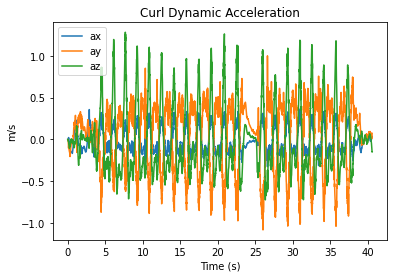

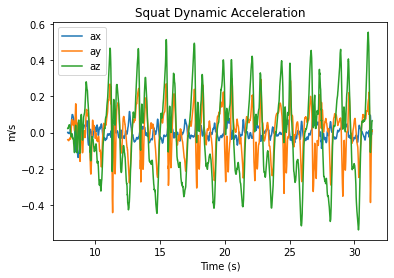

In [10]:
# READ DATA FROM data.json...
with open("data.json") as f:

    data = json.load(f)

    # Overhead Press, 9PJxOlCdxcbFBvZw7gk9
    overhead_xacc = np.array(list(data['data']["__collections__"]["history"]['9PJxOlCdxcbFBvZw7gk9']['__collections__']['raw_acc']['rawU5UtIv8orYCEkkOpJ']['xacc']))
    overhead_yacc = np.array(list(data['data']["__collections__"]["history"]['9PJxOlCdxcbFBvZw7gk9']['__collections__']['raw_acc']['rawU5UtIv8orYCEkkOpJ']['yacc']))
    overhead_zacc = np.array(list(data['data']["__collections__"]["history"]['9PJxOlCdxcbFBvZw7gk9']['__collections__']['raw_acc']['rawU5UtIv8orYCEkkOpJ']['zacc']))
    overhead_time = np.array(list(data['data']["__collections__"]["history"]['9PJxOlCdxcbFBvZw7gk9']['__collections__']['raw_time']['gu5M31wNhf8D8Z85y7j9']['time']))
    overhead_time -= overhead_time[0] 

    # Barbell Curl, bkziJY2HV6G0NF0zUUqU
    curl_xacc = np.array(list(data['data']["__collections__"]["history"]['bkziJY2HV6G0NF0zUUqU']['__collections__']['raw_acc']['snji2pTvZmPpcpogOzAX']['xacc']))
    curl_yacc = np.array(list(data['data']["__collections__"]["history"]['bkziJY2HV6G0NF0zUUqU']['__collections__']['raw_acc']['snji2pTvZmPpcpogOzAX']['yacc']))
    curl_zacc = np.array(list(data['data']["__collections__"]["history"]['bkziJY2HV6G0NF0zUUqU']['__collections__']['raw_acc']['snji2pTvZmPpcpogOzAX']['zacc']))
    curl_time = np.array(list(data['data']["__collections__"]["history"]['bkziJY2HV6G0NF0zUUqU']['__collections__']['raw_time']['lmVhWYwzYvQiVD1zGUMv']['time']))
    curl_time -= curl_time[0] 

    # Deadlift, fZXPgJEMjxIMjz5ZxXqZ
    deadlift_xacc = np.array(list(data['data']["__collections__"]["history"]['fZXPgJEMjxIMjz5ZxXqZ']['__collections__']['raw_acc']['JctsFDC1KjwU8qXO07SY']['xacc']))
    deadlift_yacc = np.array(list(data['data']["__collections__"]["history"]['fZXPgJEMjxIMjz5ZxXqZ']['__collections__']['raw_acc']['JctsFDC1KjwU8qXO07SY']['yacc']))
    deadlift_zacc = np.array(list(data['data']["__collections__"]["history"]['fZXPgJEMjxIMjz5ZxXqZ']['__collections__']['raw_acc']['JctsFDC1KjwU8qXO07SY']['zacc']))
    deadlift_time = np.array(list(data['data']["__collections__"]["history"]['fZXPgJEMjxIMjz5ZxXqZ']['__collections__']['raw_time']['aHWqtDacLbu2GfV68fYI']['time']))
    deadlift_time -= deadlift_time[0] 

    # Back Squat, lCcTdGNrsSUCUcWFpdHh
    squat_xacc = np.array(list(data['data']["__collections__"]["history"]['lCcTdGNrsSUCUcWFpdHh']['__collections__']['raw_acc']['ef2E8hh7CdHGEU5HEsX9']['xacc']))
    squat_yacc = np.array(list(data['data']["__collections__"]["history"]['lCcTdGNrsSUCUcWFpdHh']['__collections__']['raw_acc']['ef2E8hh7CdHGEU5HEsX9']['yacc']))
    squat_zacc = np.array(list(data['data']["__collections__"]["history"]['lCcTdGNrsSUCUcWFpdHh']['__collections__']['raw_acc']['ef2E8hh7CdHGEU5HEsX9']['zacc']))
    squat_time = np.array(list(data['data']["__collections__"]["history"]['lCcTdGNrsSUCUcWFpdHh']['__collections__']['raw_time']['aFWme3iCwy1vX7K4cTot']['time']))
    squat_time -= squat_time[0] 

    # Bench, sFoLqgI5afw6UcfrmxZX
    bench_xacc = np.array(list(data['data']["__collections__"]["history"]['sFoLqgI5afw6UcfrmxZX']['__collections__']['raw_acc']['l1TfF4zou5vJchT2iukX']['xacc']))
    bench_yacc = np.array(list(data['data']["__collections__"]["history"]['sFoLqgI5afw6UcfrmxZX']['__collections__']['raw_acc']['l1TfF4zou5vJchT2iukX']['yacc']))
    bench_zacc = np.array(list(data['data']["__collections__"]["history"]['sFoLqgI5afw6UcfrmxZX']['__collections__']['raw_acc']['l1TfF4zou5vJchT2iukX']['zacc']))
    bench_time = np.array(list(data['data']["__collections__"]["history"]['sFoLqgI5afw6UcfrmxZX']['__collections__']['raw_time']['Dxu4MWwfRL0l8d4nU07Q']['time']))
    bench_time -= bench_time[0] 

    #print("done reading data.json...")

# More data for later...
with open("April7-Collection.json","r+") as file:

    april_data = json.load(file)

# ::::::::::: ACCELERATION :::::::::::::
# Take out DC term from data (LPF)...
curl_ax_dyn = dc_block(curl_xacc,curl_time)
curl_ay_dyn = dc_block(curl_yacc,curl_time)
curl_az_dyn = dc_block(curl_zacc,curl_time)

bench_ax_dyn = dc_block(bench_xacc,bench_time)
bench_ay_dyn = dc_block(bench_yacc,bench_time)
bench_az_dyn = dc_block(bench_zacc,bench_time)

overhead_ax_dyn = dc_block(overhead_xacc,overhead_time)
overhead_ay_dyn = dc_block(overhead_yacc,overhead_time)
overhead_az_dyn = dc_block(overhead_zacc,overhead_time)

deadlift_ax_dyn = dc_block(deadlift_xacc,deadlift_time)
deadlift_ay_dyn = dc_block(deadlift_yacc,deadlift_time)
deadlift_az_dyn = dc_block(deadlift_zacc,deadlift_time)

squat_ax_dyn = dc_block(squat_xacc,squat_time)
squat_ay_dyn = dc_block(squat_yacc,squat_time)
squat_az_dyn = dc_block(squat_zacc,squat_time)

# TAKE OUT empty start/end of data...
c_ax_dyn = np.array(curl_ax_dyn[:4100])
c_ay_dyn = np.array(curl_ay_dyn[:4100])
c_az_dyn = np.array(curl_az_dyn[:4100])

b_ax_dyn = np.array(bench_ax_dyn[1200:3450])
b_ay_dyn = np.array(bench_ay_dyn[1200:3450])
b_az_dyn = np.array(bench_az_dyn[1200:3450])

o_ax_dyn = np.array(overhead_ax_dyn[1280:4200])
o_ay_dyn = np.array(overhead_ay_dyn[1280:4200])
o_az_dyn = np.array(overhead_az_dyn[1280:4200])

d_ax_dyn = np.array(deadlift_ax_dyn[1420:4500])
d_ay_dyn = np.array(deadlift_ay_dyn[1420:4500])
d_az_dyn = np.array(deadlift_az_dyn[1420:4500])

s_ax_dyn = np.array(squat_ax_dyn[749:2849])
s_ay_dyn = np.array(squat_ay_dyn[749:2849])
s_az_dyn = np.array(squat_az_dyn[749:2849])

plt.title("Curl Dynamic Acceleration")
plt.plot(curl_time[0:4100],c_ax_dyn,label="ax")
plt.plot(curl_time[0:4100],c_ay_dyn,label="ay")
plt.plot(curl_time[0:4100],c_az_dyn,label="az")
plt.xlabel("Time (s)")
plt.ylabel("m/s")
plt.legend()
plt.show()
plt.title("Squat Dynamic Acceleration")
plt.plot(squat_time[749:2849],s_ax_dyn,label="ax")
plt.plot(squat_time[749:2849],s_ay_dyn,label="ay")
plt.plot(squat_time[749:2849],s_az_dyn,label="az")
plt.xlabel("Time (s)")
plt.ylabel("m/s")
plt.legend()
plt.show()

In [11]:
# Data to use for future...

# :::::::: VELOCITY ::::::::
alpha = 0.97

curl_vx_dyn = simpsons_rule(curl_ax_dyn,curl_time,leaky_coeff=alpha)
curl_vy_dyn = simpsons_rule(curl_ay_dyn,curl_time,leaky_coeff=alpha)
curl_vz_dyn = simpsons_rule(curl_az_dyn,curl_time,leaky_coeff=alpha)

deadlift_vx_dyn = simpsons_rule(deadlift_ax_dyn,curl_time,leaky_coeff=alpha)
deadlift_vy_dyn = simpsons_rule(deadlift_ay_dyn,curl_time,leaky_coeff=alpha)
deadlift_vz_dyn = simpsons_rule(deadlift_az_dyn,curl_time,leaky_coeff=alpha)


squat_vx_dyn = simpsons_rule(squat_ax_dyn,curl_time,leaky_coeff=alpha)
squat_vy_dyn = simpsons_rule(squat_ay_dyn,curl_time,leaky_coeff=alpha)
squat_vz_dyn = simpsons_rule(squat_az_dyn,curl_time,leaky_coeff=alpha)

overhead_vx_dyn = simpsons_rule(overhead_ax_dyn,curl_time,leaky_coeff=alpha)
overhead_vy_dyn = simpsons_rule(overhead_ay_dyn,curl_time,leaky_coeff=alpha)
overhead_vz_dyn = simpsons_rule(overhead_az_dyn,curl_time,leaky_coeff=alpha)

bench_vx_dyn = simpsons_rule(bench_ax_dyn,curl_time,leaky_coeff=alpha)
bench_vy_dyn = simpsons_rule(bench_ay_dyn,curl_time,leaky_coeff=alpha)
bench_vz_dyn = simpsons_rule(bench_az_dyn,curl_time,leaky_coeff=alpha)

In [33]:
y_labels = []
    
y_labels.append(parse_data(b_ax_dyn,b_ay_dyn,b_az_dyn,class_ind=0)[1])
bench_atrain = parse_data(b_ax_dyn,b_ay_dyn,b_az_dyn,class_ind=0)[0]

y_labels.append(parse_data(c_ax_dyn,c_ay_dyn,c_az_dyn,class_ind=1)[1])
curl_atrain = parse_data(c_ax_dyn,c_ay_dyn,c_az_dyn,class_ind=1)[0]

y_labels.append(parse_data(s_ax_dyn,s_ay_dyn,s_az_dyn,class_ind=2)[1])
squat_atrain = parse_data(s_ax_dyn,s_ay_dyn,s_az_dyn,class_ind=2)[0]

y_labels.append(parse_data(o_ax_dyn,o_ay_dyn,o_az_dyn,class_ind=3)[1])
overhead_atrain = parse_data(o_ax_dyn,o_ay_dyn,o_az_dyn,class_ind=3)[0]

y_labels.append(parse_data(d_ax_dyn,d_ay_dyn,d_az_dyn,class_ind=4)[1])
deadlift_atrain = parse_data(d_ax_dyn,d_ay_dyn,d_az_dyn,class_ind=4)[0]

flatten = []
for arr in y_labels:
    for i in arr:
        flatten.append(i)

In [40]:
X_tensor = np.expand_dims(np.concatenate((bench_atrain, curl_atrain, squat_atrain, overhead_atrain, deadlift_atrain),axis=0),3)
y_labels = np.array(flatten) 

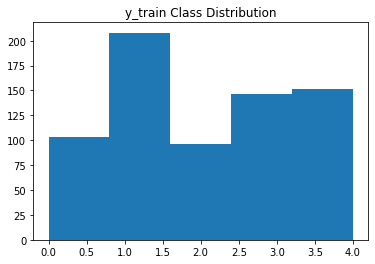

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_labels, test_size=0.2,shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

plt.title("y_train Class Distribution")
plt.hist(y_train, bins=5)
plt.show()

In [42]:
CNN = Sequential()

CNN.add(Conv2D(filters=16, kernel_size=(2,3),padding='same',data_format="channels_last"))
CNN.add(BatchNormalization())
CNN.add(Activation("relu"))
CNN.add(MaxPooling2D(pool_size=(1, 2), strides=(1, 2)))

CNN.add(Conv2D(filters=16, kernel_size=(2,3),padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation("relu"))
CNN.add(MaxPooling2D(pool_size=(1, 4), strides=(1, 4)))

CNN.add(Conv2D(filters=8, kernel_size=(2,3),padding='same'))
CNN.add(BatchNormalization())
CNN.add(Activation("relu"))
CNN.add(MaxPooling2D(pool_size=(3, 2), strides=(1, 2)))

CNN.add(Flatten())
CNN.add(Dense(units=16))
CNN.add(Activation("relu"))
CNN.add(Dropout(rate=0.5))

num_classes = 5
CNN.add(Dense(units=num_classes))

CNN.add(Activation("softmax"))

CNN.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=2e-3), metrics=['accuracy'])
CNN.fit(X_train, to_categorical(y_train), batch_size=16, epochs=20, validation_data=(X_val, to_categorical(y_val)),callbacks=[LearningRateScheduler(scheduler)])
score = CNN.evaluate(X_test, to_categorical(y_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/20
44/44 [==============================] - 1s 9ms/step - loss: 1.9607 - accuracy: 0.2514 - val_loss: 1.6027 - val_accuracy: 0.2472 - lr: 0.0020
Epoch 2/20
44/44 [==============================] - 0s 5ms/step - loss: 1.4234 - accuracy: 0.4034 - val_loss: 1.5960 - val_accuracy: 0.2809 - lr: 0.0020
Epoch 3/20
44/44 [==============================] - 0s 5ms/step - loss: 1.3573 - accuracy: 0.4134 - val_loss: 1.5842 - val_accuracy: 0.3596 - lr: 0.0020
Epoch 4/20
44/44 [==============================] - 0s 5ms/step - loss: 1.3160 - accuracy: 0.4744 - val_loss: 1.5683 - val_accuracy: 0.3258 - lr: 0.0020
Epoch 5/20
44/44 [==============================] - 0s 5ms/step - loss: 1.2613 - accuracy: 0.5085 - val_loss: 1.5428 - val_accuracy: 0.3258 - lr: 0.0020
Epoch 6/20
44/44 [==============================] - 0s 5ms/step - loss: 1.1849 - accuracy: 0.5497 - val_loss: 1.5044 - val_accuracy: 0.3933 - lr: 0.0020
Epoch 7/20
44/44 [==============================] - 0s 5ms/step - loss: 1.1505 - a

In [43]:
print(CNN.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 3, 80, 16)         112       
                                                                 
 batch_normalization_12 (Bat  (None, 3, 80, 16)        64        
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 3, 80, 16)         0         
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 3, 40, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 3, 40, 16)         1552      
                                                                 
 batch_normalization_13 (Bat  (None, 3, 40, 16)       

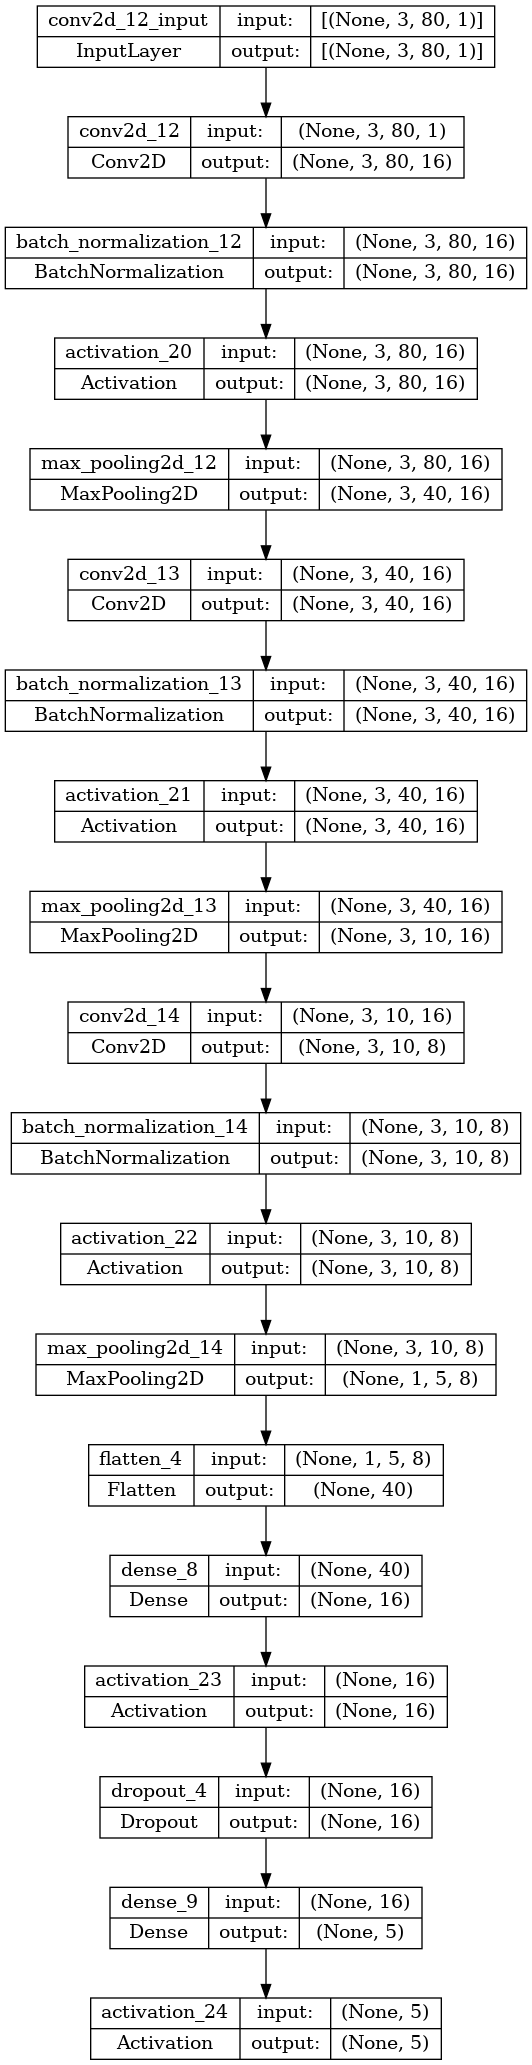

In [44]:
plot_model(CNN, to_file='model.png', show_shapes=True, show_layer_names=True)

3/3 [==============================] - 0s 3ms/step


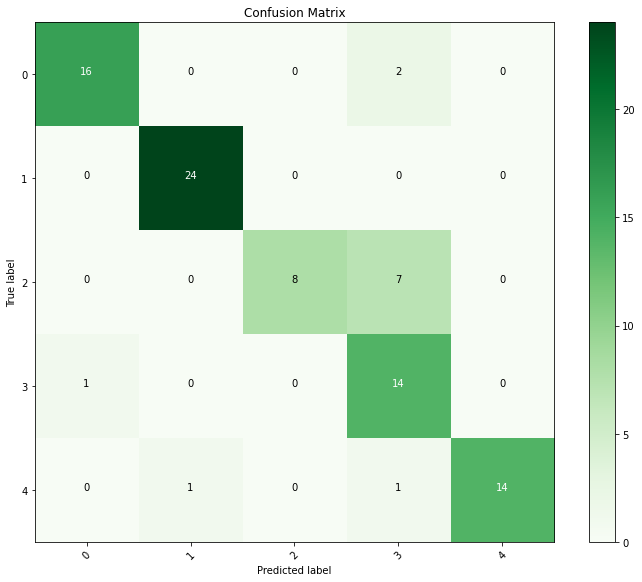

In [56]:
from sklearn.metrics import confusion_matrix
import itertools

# Generate predictions using the model
y_pred = CNN.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

confusion_mtx = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes):
    fig = plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(num_classes))

plt.show()